In [1]:
import numpy as np
import cv2

In [501]:
import pandas as pd

In [28]:
import matplotlib.pyplot as plt

In [2]:
from os import walk

In [27]:
train_path = "./data/test_profile_images"

### Load images

In [24]:
def load_images(path): 
    file_names = []
    for (dirpath, dirnames, filenames) in walk(path):
        file_names = filenames
        break
    
    img_data = []
    img_ids = []
    for f in file_names:
        if f.lower().endswith(('.png')):
            img = cv2.cvtColor(cv2.imread(f"{path}/{f}"), cv2.COLOR_BGR2RGB)
            img_data.append(img)
            img_ids.append(f.split(".")[0])
    
    return np.array(img_data), np.array(img_ids)

In [91]:
raw_data, ids = load_images(train_path)
raw_data.shape, ids.shape

((2500, 32, 32, 3), (2500,))

### Preview sample images

In [185]:
def preview_samples(data, nrows=2, ncols=3, figsize=(8, 6), cmap=None, random_seed=34):
    np.random.seed(random_seed)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for rows in axes:
        for ax in rows:
            idx = np.random.randint(data.shape[0])
            ax.imshow(data[idx], cmap=cmap)
            ax.set_title(f"sample #{idx}")

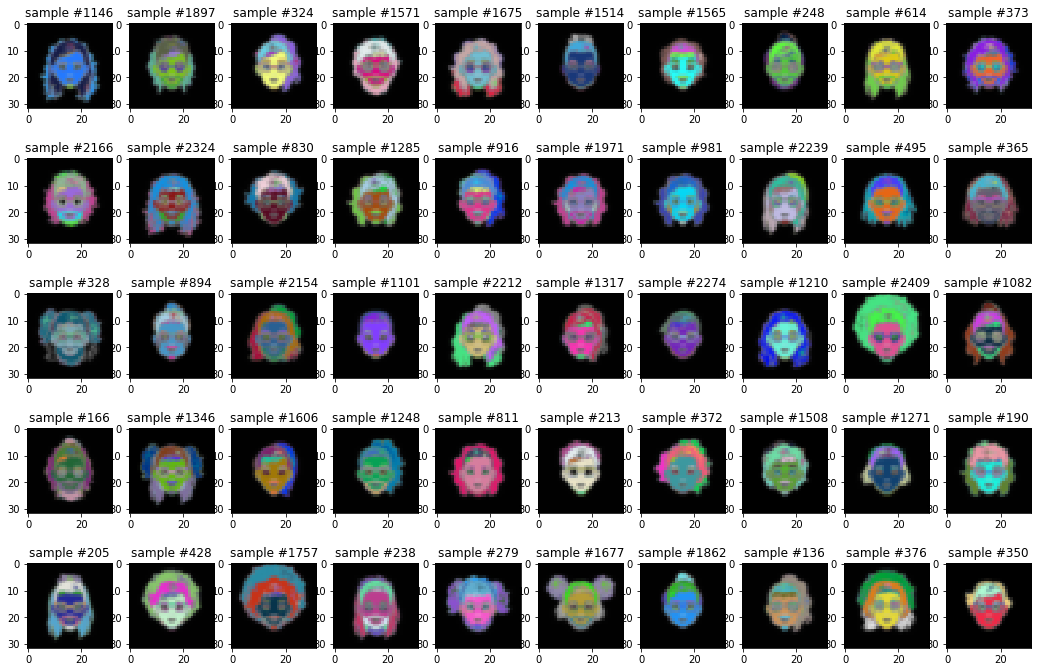

In [443]:
preview_samples(raw_data, nrows=5, ncols=10, figsize=(18, 12))

We observe from the above several images in the dataset are repeated with a change in color and some light modifications.

### Transform data

In this section, we will cluster the images based of the shape of the avatars. For this, we first covert to RGB images into a graycale format thus reducing the features size. Next, we compress the images to only keep the edges.

In [618]:
def detect_edges(data, algo="canny"):
    new_data = []
    for idx in range(data.shape[0]):
        if algo == 'laplacian':
            edges = cv2.cvtColor(data[idx], cv2.COLOR_RGB2GRAY)
        else:
            edges = cv2.Canny(data[idx], 10, 10)
        
        new_data.append(edges)
    
    return np.array(new_data)

In [703]:
edged_data = detect_edges(raw_data)
edged_data.shape

(2500, 32, 32)

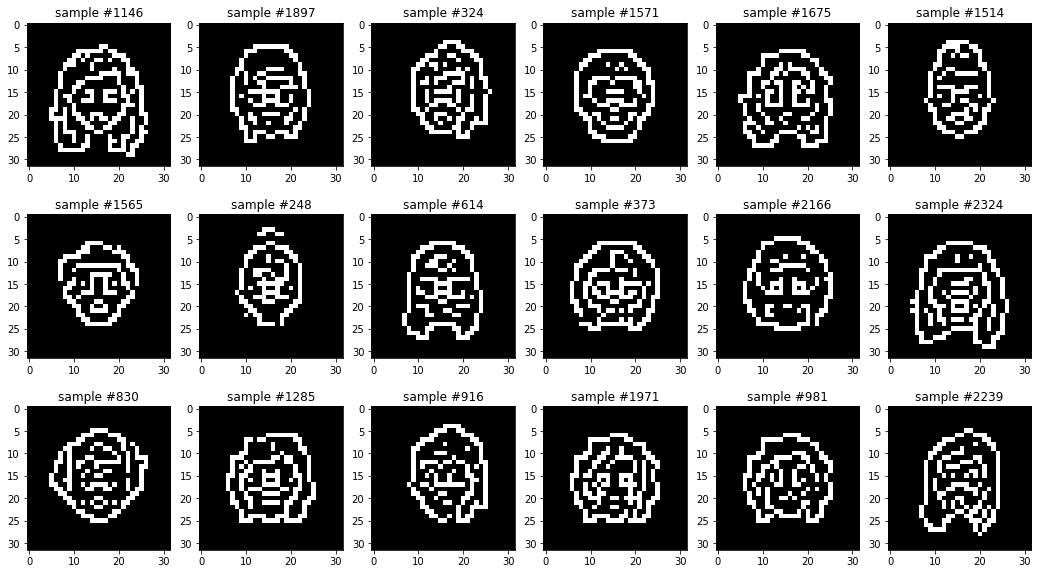

In [704]:
preview_samples(edged_data, nrows=3, ncols=6, figsize=(18, 10), cmap="binary_r")

# K-Means clustering

In [210]:
from sklearn.cluster import KMeans

In [564]:
def preview_classification(data, labels):
    for label in np.unique(labels):
        y = labels[labels == label]
        x = data[labels == label]

        print(label)
        fig, axes = plt.subplots(nrows=2, ncols=min(10, y.shape[0]), figsize=(22, 4))
        for row in axes:
            for ax in row:
                idx = np.random.randint(x.shape[0])
                ax.imshow(x[idx])
        plt.show()
        print()

### Cluster based on shape

In [702]:
def shape_clustering(data, n_classes):
    # Edge detection
    X = detect_edges(data)
    
    # Flatten images
    X = X.reshape((edged_data.shape[0], -1))
    
    kmeans = KMeans(n_clusters=n_classes, n_init=20, n_jobs=-1)
    labels = kmeans.fit_predict(X)
    
    return np.array([f"class {y}" for y in labels])

In [609]:
category_labels = shape_clustering(raw_data, n_classes=18)

class 0


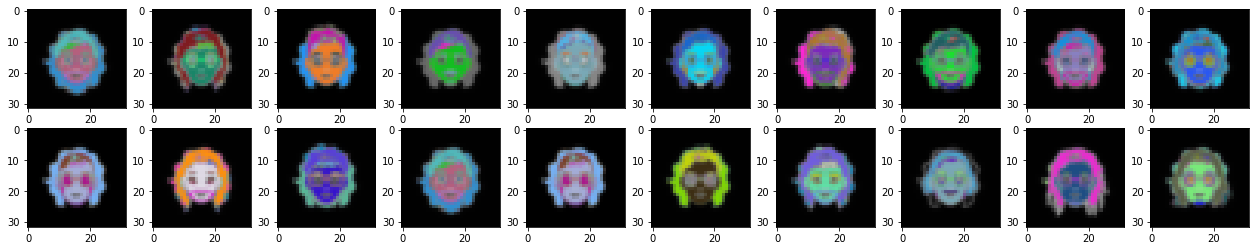


class 1


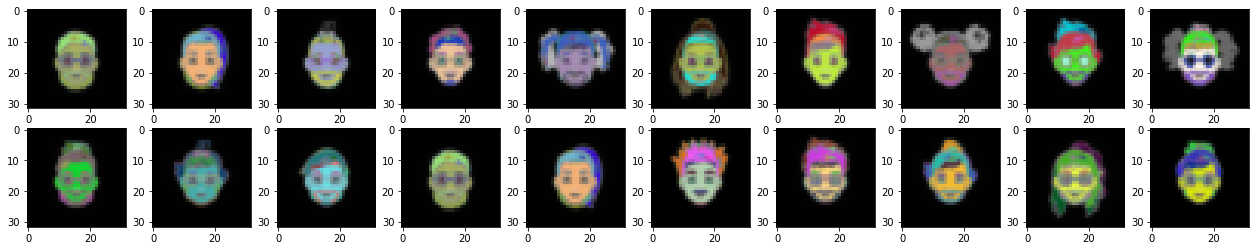


class 10


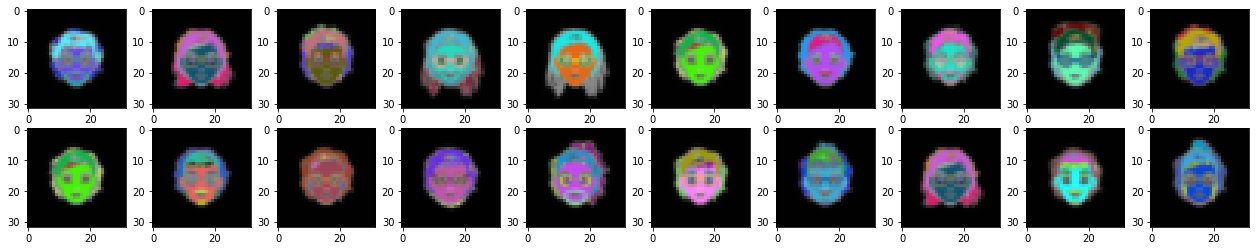


class 11


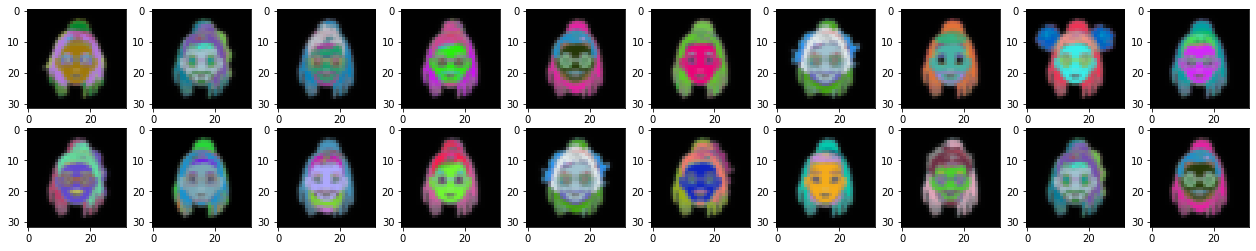


class 12


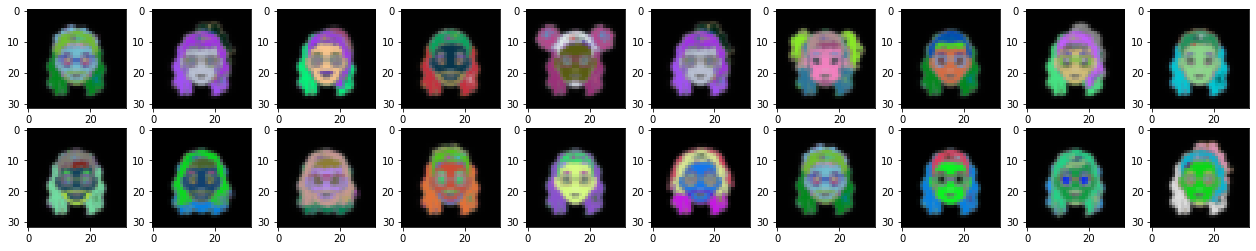


class 13


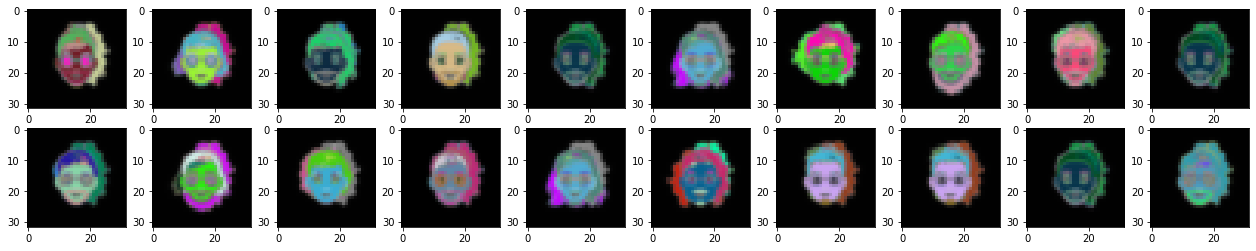


class 14


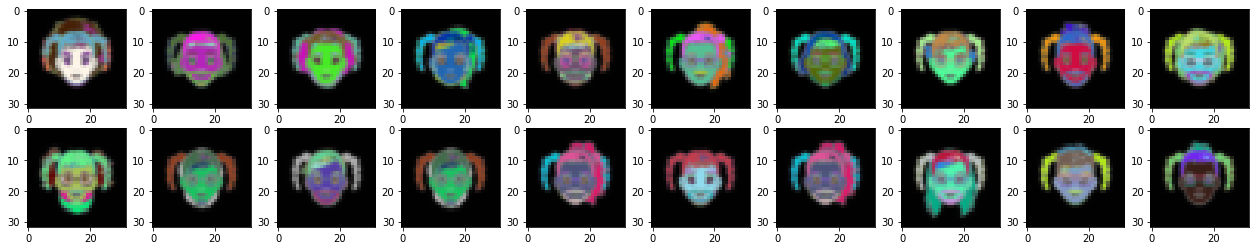


class 15


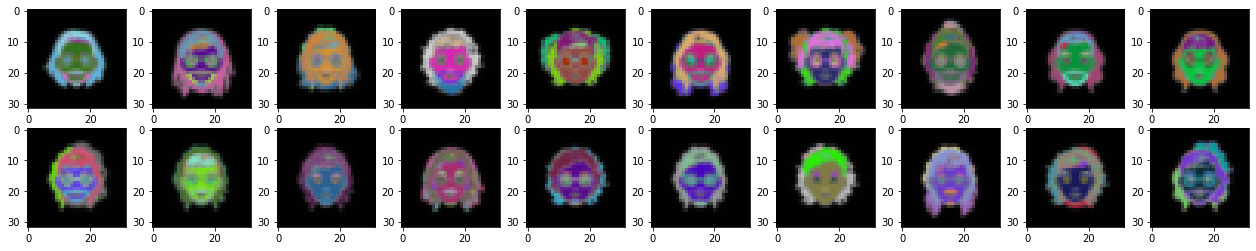


class 16


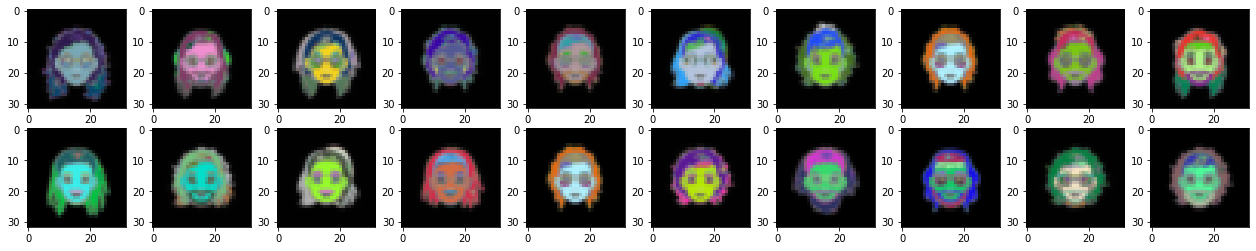


class 17


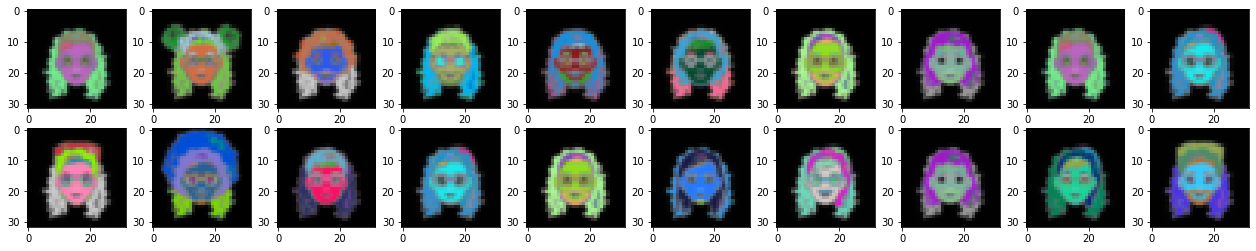


class 2


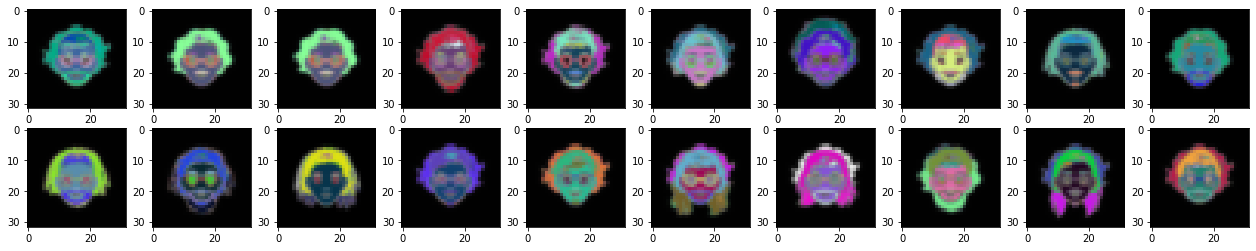


class 3


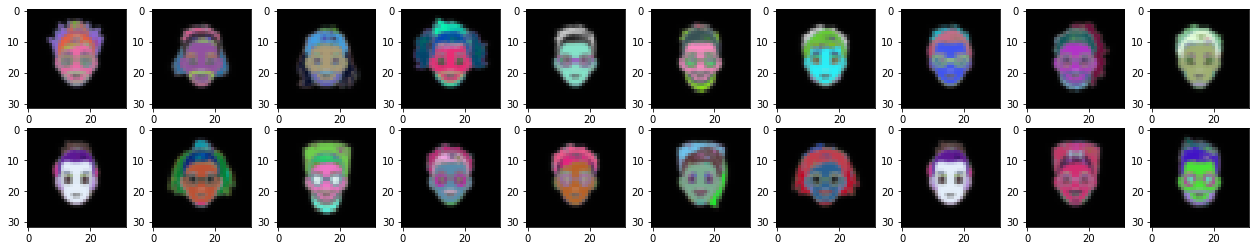


class 4


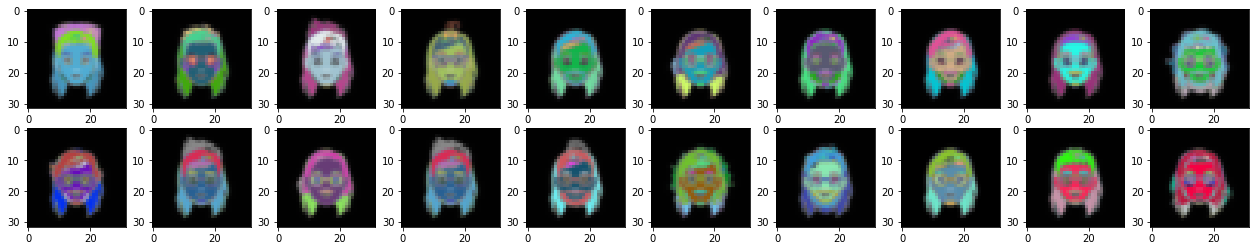


class 5


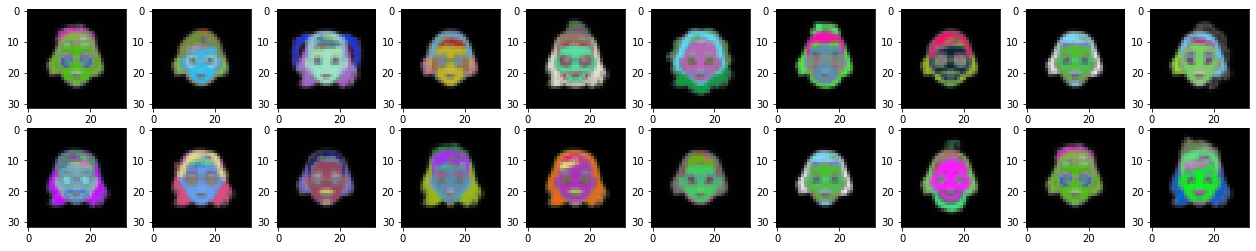


class 6


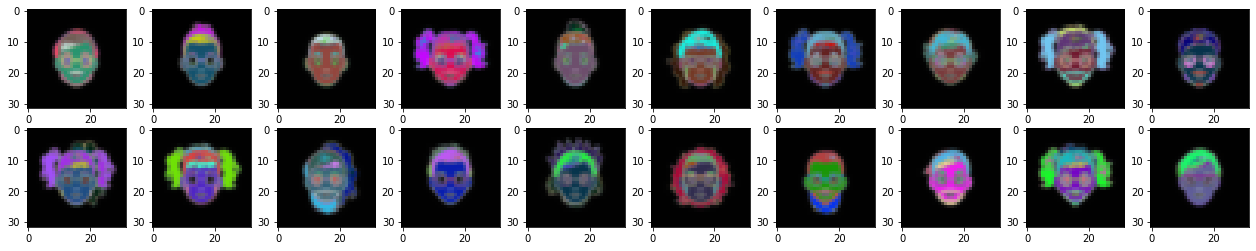


class 7


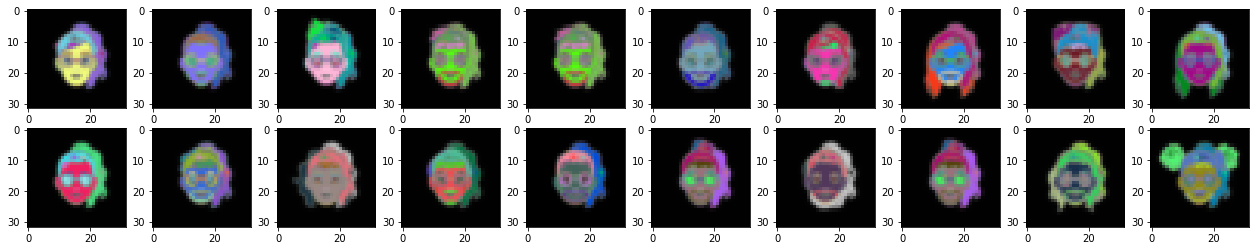


class 8


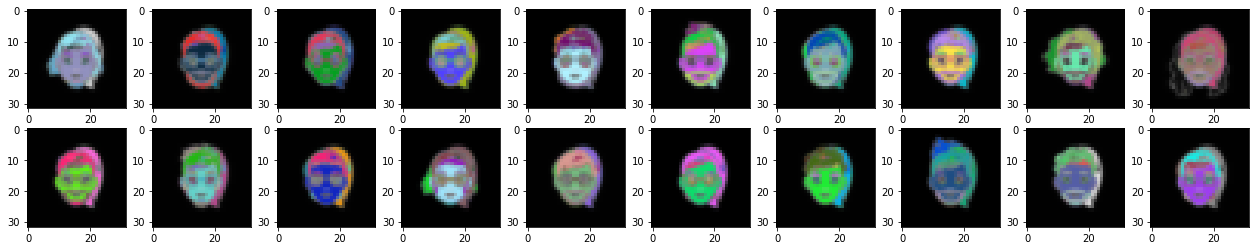


class 9


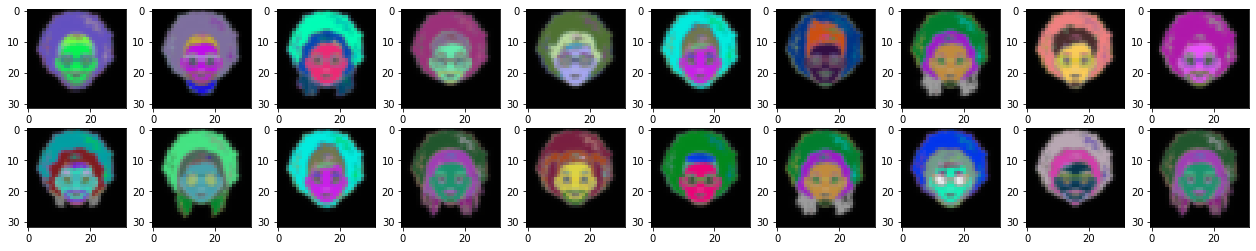

In [610]:
preview_classification(raw_data, category_labels)

The KMeans algorithms with $k=18$ appears to effectively group the avatars based on the hair style.

### Cluster based on beard

In [514]:
def crop_images(data, v, h):
    cropped = []
    for idx in range(data.shape[0]):
        cropped.append(data[idx][v[0]:v[1], h[0]:h[1]])
    
    return np.array(cropped)

In [521]:
glasses_cropped = crop_images(raw_data, v=(13,20), h=(10,22))
glasses_cropped.shape

(2500, 7, 12, 3)

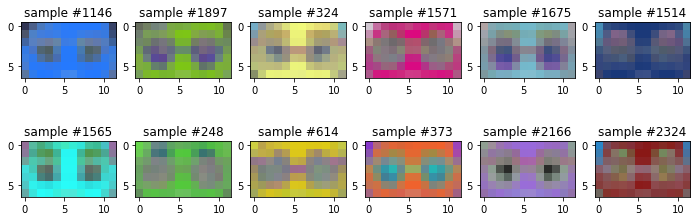

In [522]:
preview_samples(glasses_cropped, nrows=2, ncols=6, figsize=(12, 4))

In [662]:
def glasses_clustering(data):
    cropped = crop_images(data, v=(13,20), h=(10,22))
    labels = np.ones((cropped.shape[0]), dtype=np.int8)
    for idx in range(cropped.shape[0]):
        #print(cropped[idx, 1:6, 5].shape)
        mean = np.mean(cropped[idx, 2:5, 5], axis=0)
        if idx in [1146,1897,324,1571,1675,1514,1565,248,614,373,2166,2324]:
            print(idx, mean, cropped[idx][5][5], np.abs(cropped[idx][5][5] - mean))
        #print(cropped[idx, 5, 5] - mean)
        if np.any(np.abs(cropped[idx, 5, 5] - mean) < 20.0):
            labels[idx] = 0
    
    return labels

In [663]:
glasses_labels = glasses_clustering(raw_data)
glasses_labels.shape

248 [ 99.66666667 179.66666667  77.66666667] [ 83 201  60] [16.66666667 21.33333333 17.66666667]
324 [206.66666667 195.         123.        ] [235 244 123] [28.33333333 49.          0.        ]
373 [191.66666667 135.66666667  71.66666667] [239  98  45] [47.33333333 37.66666667 26.66666667]
614 [178.         145.66666667  94.66666667] [218 198  28] [40.         52.33333333 66.66666667]
1146 [ 45.66666667 122.         242.        ] [ 37 121 254] [ 8.66666667  1.         12.        ]
1514 [ 47.33333333  70.         121.66666667] [ 29  58 121] [18.33333333 12.          0.66666667]
1565 [ 40.66666667 248.33333333 243.33333333] [ 40 252 248] [0.66666667 3.66666667 4.66666667]
1571 [181.66666667  68.         118.        ] [217  10 130] [35.33333333 58.         12.        ]
1675 [125.33333333 158.66666667 172.33333333] [116 184 203] [ 9.33333333 25.33333333 30.66666667]
1897 [113.66666667 168.33333333  63.66666667] [125 198  21] [11.33333333 29.66666667 42.66666667]
2166 [157.         114.3333

(2500,)

In [623]:
glasses_edged = detect_edges(glasses_cropped, algo='laplacian')  #crop_images(edged_data, v=(13,20), h=(10,22))
glasses_edged.shape

(2500, 7, 12)

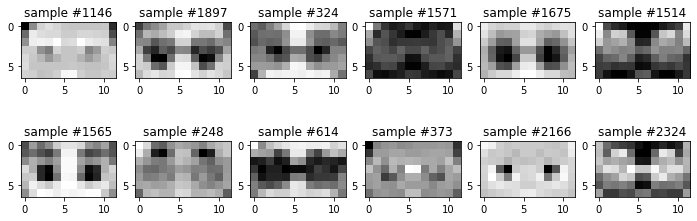

In [624]:
preview_samples(glasses_edged, nrows=2, ncols=6, figsize=(12, 4), cmap='binary_r')

In [625]:
# Flatten images
X_glasses = glasses_edged.reshape((glasses_edged.shape[0], -1))
X_glasses.shape

(2500, 84)

In [626]:
kmeans = KMeans(n_clusters=2, n_init=20, n_jobs=-1)
glasses_labels = kmeans.fit_predict(X_glasses)
glasses_labels.shape

(2500,)

Class: 0


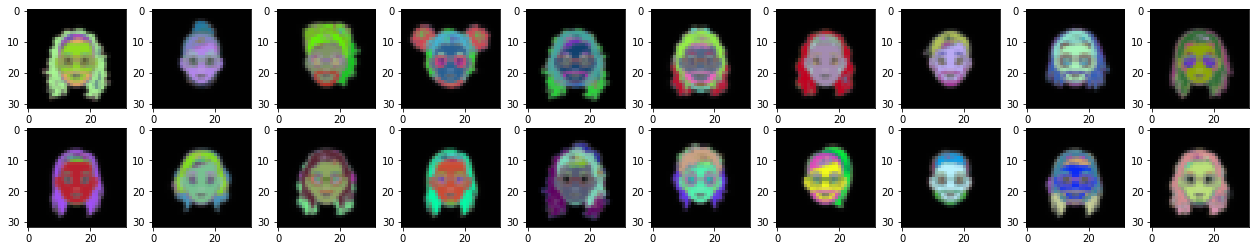


Class: 1


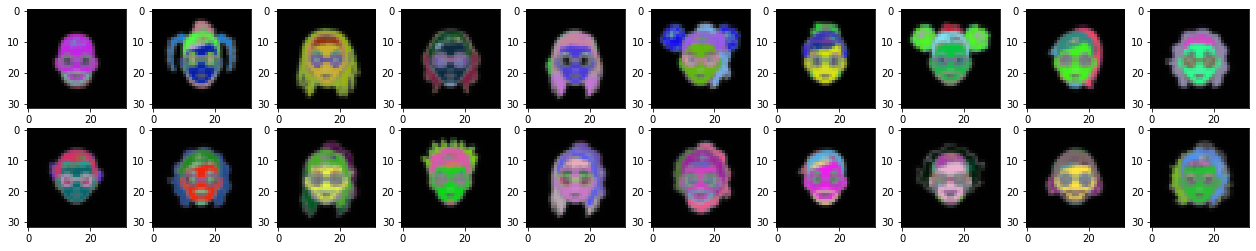

In [664]:
for label in np.unique(glasses_labels):
    y = glasses_labels[labels == label]
    x = raw_data[glasses_labels == label]

    print(f"Class: {label}")
    fig, axes = plt.subplots(nrows=2, ncols=min(10, y.shape[0]), figsize=(22, 4))
    for row in axes:
        for ax in row:
            idx = np.random.randint(x.shape[0])
            ax.imshow(x[idx])
    plt.show()
    print()

### Cluster based on Colors

Similarly, we can group the avatars based on their dominant color. We will therefore extract the dominant color in each image--excluding the darker pixels and pixels on the gray scale. We then use the RGB values as features for our KMeans clustering algorithm.

In [671]:
def extract_dominant_color(a):
    a2D = a.reshape(-1,a.shape[-1])
    keep_idx = []
    LIMIT = 35
    for idx in range(a2D.shape[0]):
        r = a2D[idx][0]
        g = a2D[idx][1]
        b = a2D[idx][2]
        
        if (r < LIMIT and g < LIMIT and b < LIMIT) or (r == g and g == b):
            pass
        else:
            keep_idx.append(idx)
    
    a2D = a2D[keep_idx]
    col_range = (256, 256, 256) # generically : a2D.max(0)+1
    a1D = np.ravel_multi_index(a2D.T, col_range)
    return np.unravel_index(np.bincount(a1D).argmax(), col_range)
        

In [672]:
def dominant_colors(data):
    colors = np.zeros((data.shape[0], 3), dtype=np.int8)
    labels = np.zeros((data.shape[0]), dtype=np.int8)
    for idx in range(data.shape[0]):
        colors[idx] = extract_dominant_color(data[idx])
        
    return colors, np.argmax(colors, axis=1)

Color: (233, 30, 52)


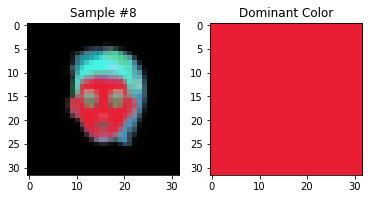

In [401]:
dominant_color = extract_dominant_color(raw_data[150])
plt.subplot(121)
plt.imshow(raw_data[150])
plt.title("Sample #8")
plt.subplot(122)
plt.imshow(np.full((32, 32, 3), np.full((32, 3), np.full((3), dominant_color))))
plt.title("Dominant Color")
print(f"Color: {dominant_color}")

In [402]:
dominant_colors, color_labels = dominant_colors(raw_data)
dominant_colors.shape, color_labels.shape

((2500, 3), (2500,))

In [406]:
from mpl_toolkits.mplot3d import Axes3D

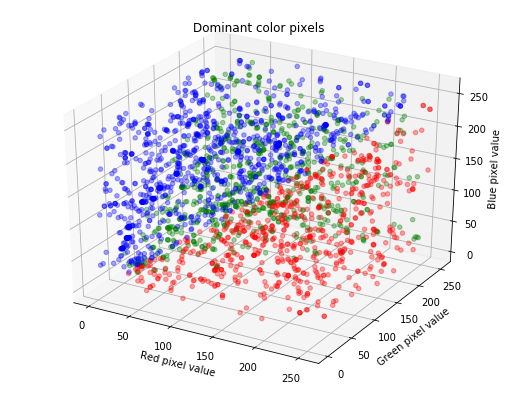

In [534]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

for m, color, c in [('o', 'Red', 0), ('o', 'Green', 1), ('o', 'Blue', 2)]:
    xs = dominant_colors[color_labels == c][:, 0]
    ys = dominant_colors[color_labels == c][:, 1]
    zs = dominant_colors[color_labels == c][:, 2]
    ax.scatter(xs, ys, zs, marker=m, c=color, alpha=0.35)

ax.set_xlabel('Red pixel value')
ax.set_ylabel('Green pixel value')
ax.set_zlabel('Blue pixel value')

ax.set_title('Dominant color pixels')

plt.show()

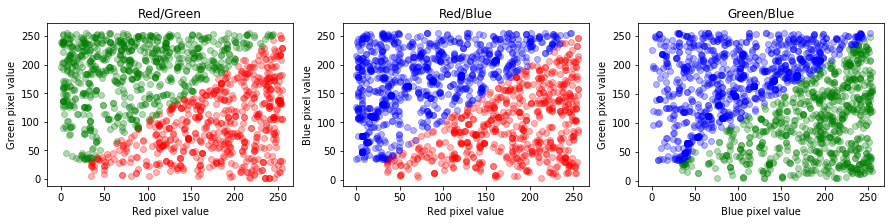

In [440]:
plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.title("Red/Green")
plt.scatter(dominant_colors[color_labels == 0][:, 0], dominant_colors[color_labels == 0][:, 1], c='Red', alpha=0.3)
plt.scatter(dominant_colors[color_labels == 1][:, 0], dominant_colors[color_labels == 1][:, 1], c='Green', alpha=0.3)
plt.xlabel("Red pixel value")
plt.ylabel("Green pixel value")

plt.subplot(132)
plt.title("Red/Blue")
plt.scatter(dominant_colors[color_labels == 0][:, 0], dominant_colors[color_labels == 0][:, 2], c='Red', alpha=0.3)
plt.scatter(dominant_colors[color_labels == 2][:, 0], dominant_colors[color_labels == 2][:, 2], c='Blue', alpha=0.3)
plt.xlabel("Red pixel value")
plt.ylabel("Blue pixel value")

plt.subplot(133)
plt.title("Green/Blue")
plt.scatter(dominant_colors[color_labels == 1][:, 1], dominant_colors[color_labels == 1][:, 2], c='Green', alpha=0.3)
plt.scatter(dominant_colors[color_labels == 2][:, 1], dominant_colors[color_labels == 2][:, 2], c='Blue', alpha=0.3)
plt.xlabel("Blue pixel value")
plt.ylabel("Green pixel value")

plt.show()

We can see from the plots above that there is a clear separation between images with dominant color in each of the RGB colors. The simple appears to give satisfying results. There is no need for a ML model such as KMeans.

In [701]:
def color_clustering(data):
    colors_map = {0: 'red', 1: 'green', 2: 'blue'}
    colors, color_labels = dominant_colors(raw_data)
    return np.array([colors_map[y] for y in color_labels])

0


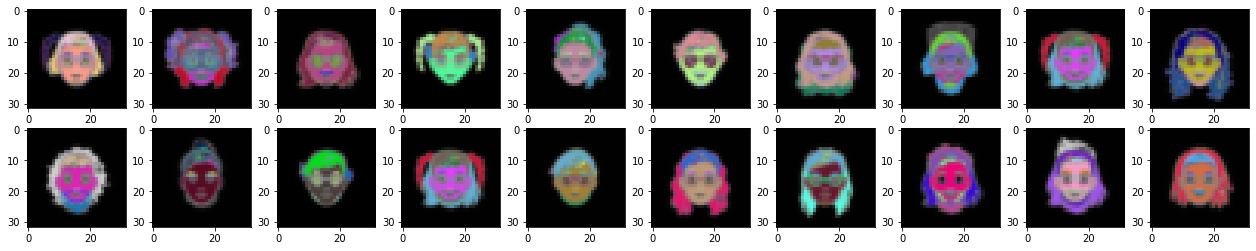


1


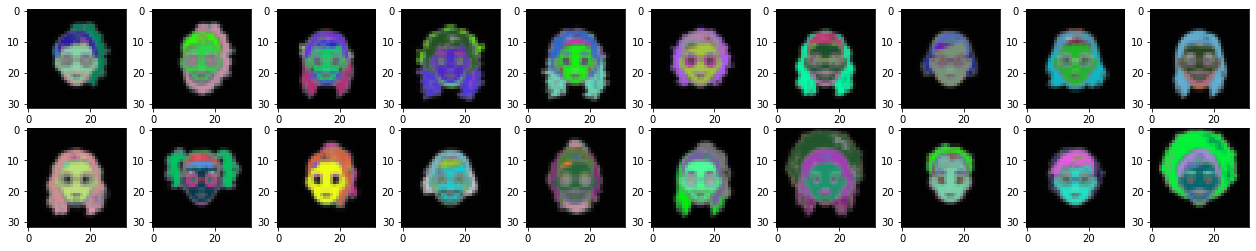


2


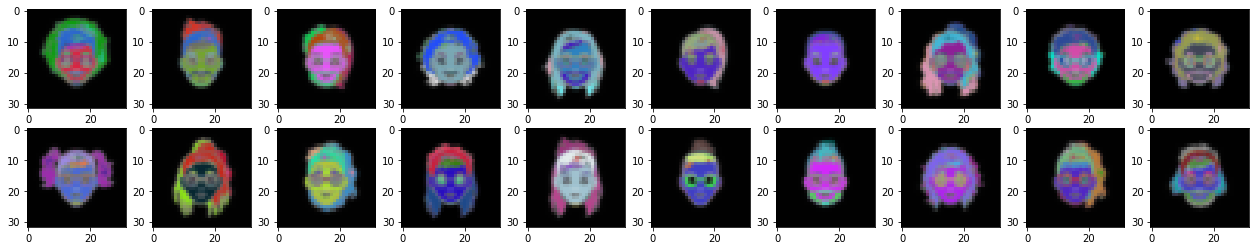

In [665]:
preview_classification(raw_data, color_labels)

# Export features

In [676]:
def export_features(data, ids):
    df = pd.DataFrame(ids, columns=['Id'])
    # Cluster based on shape
    df['profile_image_category_18'] = shape_clustering(data, 18)
    df['profile_image_category_13'] = shape_clustering(data, 13)
    df['profile_image_category_8'] = shape_clustering(data, 8)
    
    # Cluster based on dominant color
    df['profile_image_dominant_color'] = color_clustering(data)
    
    df = df.set_index("Id")
    df.to_csv("./data/train_profile_images.csv")
    
    return df

In [ ]:
df = export_features(raw_data, ids)
df.head()